    SEASON_ID     TEAM_ID TEAM_ABBREVIATION             TEAM_NAME     GAME_ID  \
126     22023  1610612745               HOU       Houston Rockets  1522300076   
128     22023  1610612740               NOP  New Orleans Pelicans  1522300068   
129     22023  1610612742               DAL      Dallas Mavericks  1522300074   
130     22023  1610612762               UTA             Utah Jazz  1522300071   
131     22023  1610612765               DET       Detroit Pistons  1522300070   

      GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
126  2023-07-17    HOU @ CLE  L  198   78  ...   0.643     9    28   37   15   
128  2023-07-16  NOP vs. PHI  L  200  114  ...   0.778    18    27   45   27   
129  2023-07-16  DAL vs. ATL  W  200  101  ...   0.810     8    34   42   17   
130  2023-07-16    UTA @ HOU  L  200  101  ...   0.833    15    29   44   22   
131  2023-07-16    DET @ IND  W  199  100  ...   0.643     8    36   44   15   

     STL  BLK  TOV  PF  PLUS_MIN

C:\Users\ghadf\AppData\Local\Temp\ipykernel_23612\1033051381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))
C:\Users\ghadf\AppData\Local\Temp\ipykernel_23612\1033051381.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_23612\1033051381.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy

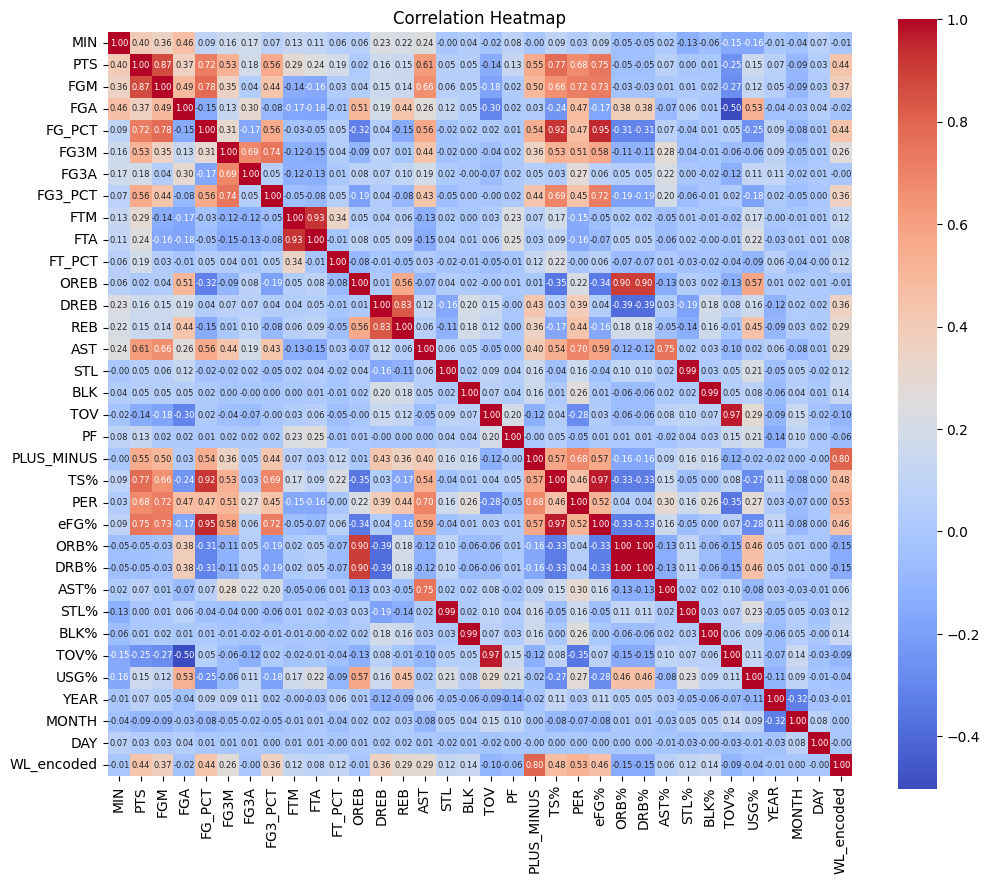

In [42]:
#todos: normalize the stats, add in the teams from 1979 on that are missing from the data,

from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

teams = teams.get_teams()
#print(teams)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)
print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / MIN
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])/ data['MIN']

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding ORB%
data['ORB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding DRB%
data['DRB%'] = data['OREB'] / (data['OREB'] + data['DREB'])

#adding TRB% ***not sure if this is correct, it's not working
#data['TRB%'] = (data['OREB'] + data['DREB']) / data['REB']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding STL%
data['STL%'] = data['STL'] / data['MIN']

#adding BLK%
data['BLK%'] = data['BLK'] / data['MIN']

#adding TOV%
data['TOV%'] = data['TOV'] / (data['FGA'] + 0.44 * data['FTA'] + data['TOV'])

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']

#adding OWS
#adding DWS
#adding WS
3#adding WS/48
#adding OBPM
#adding DBPM
#adding BPM
#adding VORP
#adding O/D Rating
#adding O/D Win Shares
#adding O/D Win Shares
#adding O/D WS/48
#adding O/D BPM
#adding O/D BPM
#adding O/D VORP
#adding O/D VORP

#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Convert all non-numeric values in a column
# Encode non-numeric values in the 'TEAM_ID' column as categorical variables
data_encoded = pd.get_dummies(data, columns=['TEAM_ID'], prefix='TEAM')


#**Drop Missing values
# Drop rows with missing values
data_encoded = data_encoded.dropna()

# Filter the data to include only selected columns
data_encoded_selected = data_encoded.iloc[:, :40]


# Check the updated column names in the DataFrame
print('encoded_data = ',data_encoded_selected.columns)
#print(data_encoded_selected)

# Filter the data for the 2022-2023 NBA season - changing to 1979-2023
#could also use season_id = 42022
start_date = pd.to_datetime('1979-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded_selected[(data_encoded_selected['GAME_DATE'] >= start_date) & (data_encoded_selected['GAME_DATE'] <= end_date)].copy()

# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data.head())


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 6})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'

# Update season_data with encoded features
labelencoder = LabelEncoder()
season_data['TEAM_NAME'] = labelencoder.fit_transform(season_data['TEAM_NAME'])
season_data['MATCHUP'] = labelencoder.fit_transform(season_data['MATCHUP'])

# Drop any rows with missing values from season_data
season_data.dropna(inplace=True)

# Define X and y using the updated season_data DataFrame
#Dropping anything with a negative correlation according to the heatmap
X = season_data.drop(columns=[y_column,'GAME_DATE','TEAM_ABBREVIATION','WL','ORB%','DRB%','FGA','TOV','TOV%','USG%','FG3A','OREB','PF'])
y = season_data[y_column]

print(X) #checking on the columns to ensure coded and the length is long enough for the season/playoffs

# Confirm the shape of X and y after handling missing values and encoding
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)




      SEASON_ID  TEAM_NAME     GAME_ID  MATCHUP  MIN  PTS  FGM  FG_PCT  FG3M  \
660       42022          6  0042200405      396  240   94   38   0.452     5   
661       42022         14  0042200405      837  240   89   33   0.344     9   
685       42022          6  0042200404      367  242  108   39   0.494    14   
690       42022         14  0042200404      866  240   95   35   0.449     8   
709       42022          6  0042200403      367  238  109   41   0.513     5   
...         ...        ...         ...      ...  ...  ...  ...     ...   ...   
29921     12018          8  0011800005      516  241  110   44   0.473    12   
29922     12018         23  0011800003     1390  239  104   37   0.420    12   
29924     12018          3  0011800002      207  241  104   34   0.382    11   
29925     12018          1  0011800002      120  238   97   36   0.346     9   
29926     12018         21  0011800001     1287  239  104   41   0.482     6   

       FG3_PCT  ...  PLUS_MINUS       T

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Get the team names from the original dataset for the test set
team_names_test = season_data.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)
game_ids_test = season_data.loc[X_test.index, 'GAME_ID'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'GAME_ID': game_ids_test,'TEAM_NAME': team_names_test, 'Probability': y_pred_lr})

# Remove duplicates from df1 based on 'player_name' column
team_abbrev_unique = season_data.drop_duplicates(subset='TEAM_ABBREVIATION')

# Perform the merge between probabilities_df_lr and team_abbrev_unique to add abbreviations
probabilities_df_lr = probabilities_df_lr.merge(team_abbrev_unique[['TEAM_NAME', 'TEAM_ABBREVIATION']], on='TEAM_NAME', how='left')

# Remove duplicates from df1 based on 'player_name' column
game_matchups = data_encoded_selected.drop_duplicates(subset='GAME_ID')

# Perform the merge between probabilities_df_lr and game_matchups to add matchups
probabilities_df_lr = probabilities_df_lr.merge(game_matchups[['GAME_ID', 'MATCHUP','GAME_DATE']], on='GAME_ID', how='left')

# Map probabilities to binary outcomes (W or L) based on a threshold of 0.5
probabilities_df_lr['Prediction'] = probabilities_df_lr['Probability'].apply(lambda x: 'W' if x >= 0.5 else 'L')

# Reset the index of probabilities_df_lr for proper display
probabilities_df_lr.reset_index(drop=True, inplace=True)

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print("Linear Regression Predictions:")
print(probabilities_df_lr)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"LR R-squared: {r2_lr:.2f}")
print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression Predictions:
         GAME_ID  TEAM_NAME  Probability TEAM_ABBREVIATION      MATCHUP  \
2663  0011800004          5     2.009723               DAL  DAL vs. BJD   
1783  0021800383          1     1.927246               BOS    BOS @ CHI   
2662  0011800006         27     1.915800               UTA  UTA vs. PER   
2127  0021800210          5     1.889967               DAL  DAL vs. UTA   
2551  0011800067         11     1.747108               LAC  LAC vs. MAC   
...          ...        ...          ...               ...          ...   
2036  0021800259         23    -0.648548               POR  MIL vs. POR   
2114  0021800214          0    -0.712937               ATL  DEN vs. ATL   
308   0021801150          3    -0.735488               CHA    CHA @ GSW   
2138  0021800210         27    -0.888810               UTA  DAL vs. UTA   
1786  0021800383          4    -0.990666               CHI    BOS @ CHI   

      GAME_DATE Prediction  
2663 2018-09-29          W  
1783 2018-

In [45]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Predict using the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall:", logreg_recall)
print("Logistic Regression F1-score:", logreg_f1)
print("Logistic Regression Confusion Matrix:")
print(logreg_confusion_matrix)

#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

Logistic Regression Accuracy: 0.5106781566129637
Logistic Regression Precision: 0.5106781566129637
Logistic Regression Recall: 1.0
Logistic Regression F1-score: 0.6760912698412699
Logistic Regression Confusion Matrix:
[[   0 1306]
 [   0 1363]]


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#For Random Forest, feature scaling is generally not required, and it is one of the algorithms that is inherently robust to varying scales of features. 
# The reason behind this is that decision trees, which form the basis of the Random Forest algorithm, make splits based on comparisons of individual 
# features at each node. These splits are chosen based on the feature values that optimize certain criteria (e.g., Gini impurity or information gain) to separate the data effectively.

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier with desired hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics for the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)
#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.


Random Forest Accuracy: 0.9958786062195579
Random Forest Precision: 0.9970193740685543
Random Forest Recall: 0.9947955390334573
Random Forest F1-score: 0.9959062151097879
Random Forest Confusion Matrix:
[[1320    4]
 [   7 1338]]


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler: MinMaxScaler is great for gradient descent-based algorithms
#Scaling for Gradient Descent-based algorithms (e.g., Linear Regression): For gradient descent algorithms, scaling can improve convergence speed.
#  impprove the performance of the model (by .1% so far)
scaler_gd = MinMaxScaler()

# Fit and transform the data using the scaler
data_scaled_gd = scaler_gd.fit_transform(X)

#print("Scaled data for Gradient Descent-based algorithms:")
#print(data_scaled_gd)


# Assuming you have already prepared the X (features) and y (target) data
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier model and fit it to the training data
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_gb = gb_model.predict(X_test)

# Calculate metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_confusion_matrix = confusion_matrix(y_test, y_pred_gb)

# Print the evaluation metrics
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Precision:", gb_precision)
print("Gradient Boosting Recall:", gb_recall)
print("Gradient Boosting F1-score:", gb_f1)
print("Gradient Boosting Confusion Matrix:")
print(gb_confusion_matrix)
#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.


Gradient Boosting Accuracy: 0.9962532783814163
Gradient Boosting Precision: 0.9977628635346756
Gradient Boosting Recall: 0.9947955390334573
Gradient Boosting F1-score: 0.996276991809382
Gradient Boosting Confusion Matrix:
[[1321    3]
 [   7 1338]]


In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Initialize the scaler: great for KNN and svm models
scaler_svm = StandardScaler()

# Fit and transform the data using the scaler
data_scaled_svm = scaler_svm.fit_transform(X)

print("Scaled data for SVM:")
print(data_scaled_svm)

# SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)

# Print the evaluation metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1-score:", svm_f1)
print("SVM Confusion Matrix:")
print(svm_confusion_matrix)

#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

Scaled data for SVM:
[[ 3.38736832 -0.95551845 -0.12831654 ...  1.55742212 -0.00795175
  -0.36400867]
 [ 3.38736832  0.0038912  -0.12831654 ...  1.55742212 -0.00795175
  -0.36400867]
 [ 3.38736832 -0.95551845 -0.12831654 ...  1.55742212 -0.00795175
  -0.7013955 ]
 ...
 [-1.90874408 -1.31529707 -0.23573473 ... -1.74536809  0.7042371
   1.43538779]
 [-1.90874408 -1.55514948 -0.23573473 ... -1.74536809  0.7042371
   1.43538779]
 [-1.90874408  0.84337464 -0.23573473 ... -1.74536809  0.7042371
   1.43538779]]
SVM Accuracy: 0.4998126639190708
SVM Precision: 0.501929012345679
SVM Recall: 0.9672862453531599
SVM F1-score: 0.6609093218186436
SVM Confusion Matrix:
[[  33 1291]
 [  44 1301]]
